In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from sklearn.metrics.pairwise import cosine_similarity

import joblib


# **Food Recommendation Based on Collaborative Filtering**

by **Naufal Fajar Revanda** - [LinkedIn](https://www.linkedin.com/in/naufalrevanda/) - [GitHub](https://github.com/nrevanda)

## **Introduction**

**Context**

In today’s highly competitive e-commerce landscape, delivering a personalized shopping experience has become essential for both retaining customers and driving sales growth. One of the most powerful ways to achieve this is through **recommendation systems**, which guide users toward products they are likely to enjoy. Beyond enhancing convenience for shoppers, these systems give platforms a clear competitive edge by **encouraging cross-selling** and **up-selling opportunities**.

**Problem Statement**

**The Amazon Fine Food Reviews** dataset contains more than 500,000 product reviews. With such an overwhelming number of options, **users often struggle to find products that truly match their tastes**. At the same time, platforms face the challenge of recommending relevant new products when there is little to no purchase history from other customers. This issue, commonly referred to as information overload, calls for intelligent solutions to bridge the gap between the vast volume of product data and the unique preferences of each individual user.

**Goals**

The primary goal of this project is to develop and implement a recommendation system capable of predicting and suggesting food products to users. Specifically, the project will:

- Build an **Item-Based Collaborative Filtering model**: This technique will be used to identify similarities between products based on user rating patterns.

- **Deliver relevant recommendations**: Provide users with a list of products they are most likely to enjoy, derived from their interactions with other items.

**Dataset and Feature**

Dataset: [Amazon Fine Food Reviews](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews/data)

| Features            | Description                                    |
|-----------------------|------------------------------------------------|
| **Id**            | Row Id                                 |
| **ProductId**       | Unique identifier for the product              |
| **UserID** | Unqiue identifier for the user        |
| **ProfileName**      | Profile name of the user          |
| **HelpfulnessNumerator**            | Number of users who found the review helpfu                              |
| **HelpfulnessDenominator**          | Number of users who indicated whether they found the review helpful or not                             |
| **Score**       | Rating between 1 and 5                          |
| **Time**         | Timestamp for the review   |
| **Summary** | Brief summary of the review |
| **Text**               | Text of the review                                |

## **Exploratory Data Analysis**

In [123]:
# import the data
df = pd.read_csv(r'D:\Documents\0. JCDS\Portofolio\3. Recommendation System\amazon-fine-food-reviews\reviews.csv')

### **1. Load and View Initial Data**

In [124]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


### **2. Basic Statistical Analysis**

In [126]:
# rows and columns
print(f'Number of row: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

Number of row: 568454
Number of columns: 10


In [127]:
# descriptive statistics
display(df.describe())
display(df.describe(include='object'))

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


,ProductId,UserId,ProfileName,Summary,Text
count,568454,568454,568428,568427,568454
unique,74258,256059,218415,295742,393579
top,B007JFMH8M,A3OXHLG6DIBRW8,"C. F. Hill ""CFH""",Delicious!,"This review will make me sound really stupid, ..."
freq,913,448,451,2462,199


In [128]:
print(f'Number of unique user: {df['UserId'].nunique()}')
print(f'Number of unique product: {df['ProductId'].nunique()}')

Number of unique user: 256059
Number of unique product: 74258


### **3. Missing Values**

,total,null_count,null_pct
column,,,
Id,568454,0,0.00000
ProductId,568454,0,0.00000
UserId,568454,0,0.00000
ProfileName,568454,26,0.00457
HelpfulnessNumerator,568454,0,0.00000
HelpfulnessDenominator,568454,0,0.00000
Score,568454,0,0.00000
Time,568454,0,0.00000
Summary,568454,27,0.00475


<Axes: >

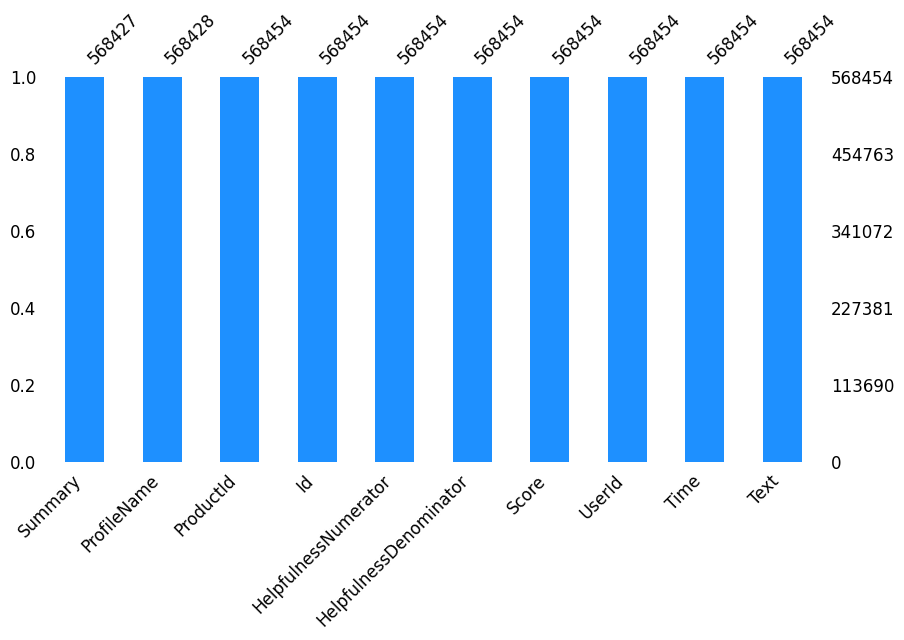

In [129]:
# missing values
missing_value_check = pd.DataFrame({
    "total": [df.shape[0]] * len(df.columns),
    "null_count": df.isna().sum().values,
    "null_pct": (df.isna().sum() / df.shape[0] * 100).round(5).values,
}, index=df.columns).rename_axis('column')

display(missing_value_check)
display(msno.bar(df,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12))

### **4. Rating Distribution**

C:\Users\nreva\AppData\Local\Temp\ipykernel_17392\1639733872.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Score', palette=colors)


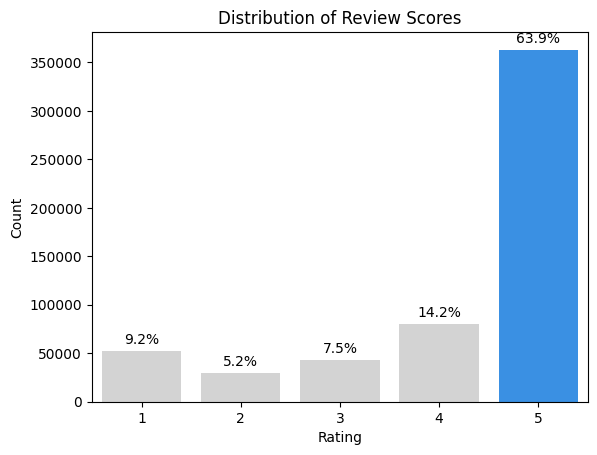

In [130]:
categories = sorted(df['Score'].unique())
colors = ["lightgray" if cat != 5 else "dodgerblue" for cat in categories]

ax = sns.countplot(data=df, x='Score', palette=colors)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Review Scores')

total = len(df)

for p in ax.patches:
    height = p.get_height()
    percentage = 100 * height / total
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 8), textcoords='offset points')

plt.show()

### **5. User Activity and Product Popularity**

C:\Users\nreva\AppData\Local\Temp\ipykernel_17392\3759147108.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users.index, y=top_users.values, palette="Blues_r")


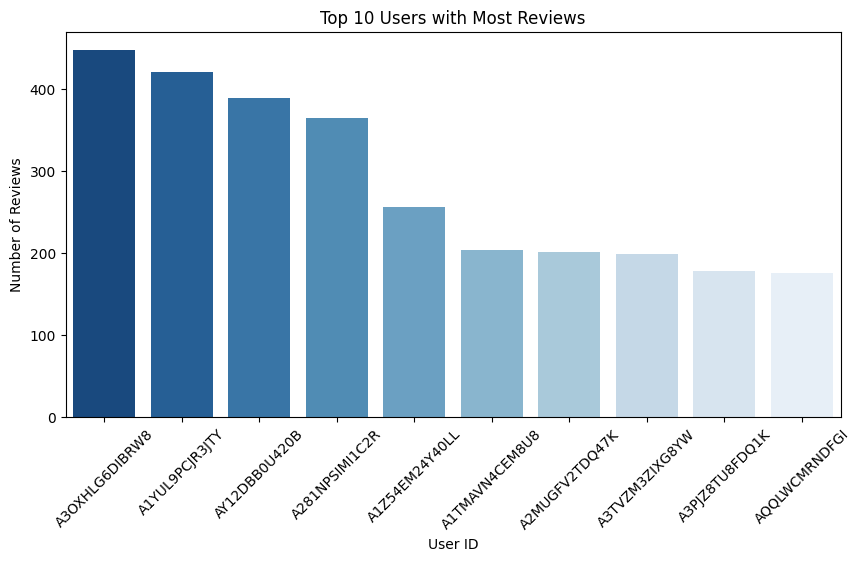

In [131]:
top_users = df['UserId'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_users.index, y=top_users.values, palette="Blues_r")
plt.title("Top 10 Users with Most Reviews")
plt.xlabel("User ID")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.show()


C:\Users\nreva\AppData\Local\Temp\ipykernel_17392\847394406.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.index, y=top_products.values, palette="Blues_r")


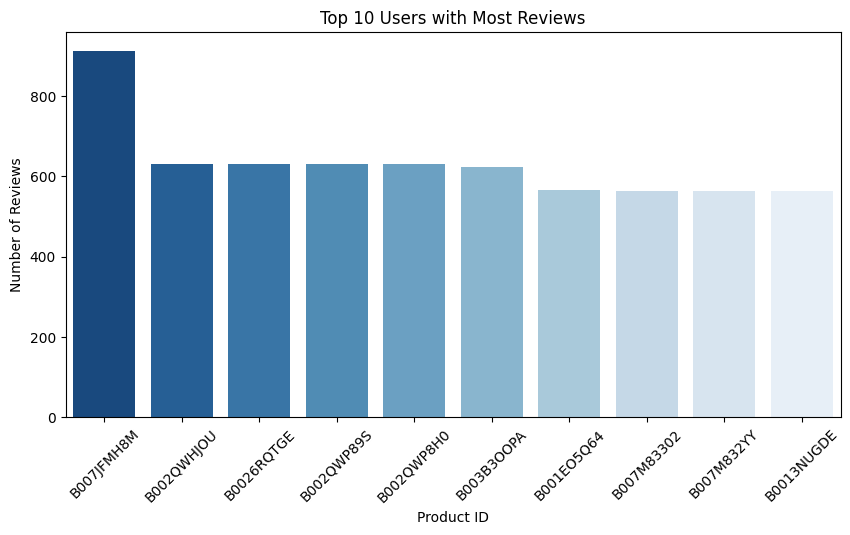

In [132]:
top_products = df['ProductId'].value_counts().head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_products.index, y=top_products.values, palette="Blues_r")
plt.title("Top 10 Users with Most Reviews")
plt.xlabel("Product ID")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.show()

## **Data Cleaning**

### **1. Drop irrevant columns**
- in this case, columns we need is only `ProductID`, `UserdID`, and `Score` in long format

In [133]:
# drop the irrelevant columns
df = df.drop(columns=['Id','ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary', 'Text'])
df.head()

,ProductId,UserId,Score
0,B001E4KFG0,A3SGXH7AUHU8GW,5
1,B00813GRG4,A1D87F6ZCVE5NK,1
2,B000LQOCH0,ABXLMWJIXXAIN,4
3,B000UA0QIQ,A395BORC6FGVXV,2
4,B006K2ZZ7K,A1UQRSCLF8GW1T,5


### **2. Limit the data**
Take the subset of dataset to make it less sparse (for demo purposes)

In [134]:
# Count the number of reviews per product and take the top 50 products
top_products = df['ProductId'].value_counts().head(50).index.tolist()
df_filtered = df[df['ProductId'].isin(top_products)]

# Count the number of reviews per user on the filtered products
top_users = df_filtered['UserId'].value_counts().head(500).index.tolist()
df_final = df_filtered[df_filtered['UserId'].isin(top_users)]

df_final = df_final.reset_index(drop=True)
print(f"Number of records after filtering: {len(df_final)}")

Number of records after filtering: 4837


In [135]:
df_final.head()

,ProductId,UserId,Score
0,B006N3IG4K,AQ6SHOW0VMZGF,2
1,B006N3IG4K,A35R32TA60XD57,5
2,B006N3IG4K,AP03SDCDB6RBD,5
3,B006N3IG4K,AQ6SHOW0VMZGF,3
4,B006N3IG4K,ABQN42N7ICNZQ,4


## **Build Collaboratotrive Model**

In [136]:
user_item_matrix = pd.pivot_table(df_final,index=['UserId'], columns = 'ProductId', values = "Score")
user_item_matrix.fillna(0,inplace=True)

user_item_matrix.head()

ProductId,B000CNB4LE,B000KV61FC,B000KV7ZGQ,B000NMJWZO,B000PDWBKO,B000PDY3HI,B000PDY3P0,B000VK8AVK,B0013NUGDE,B001EO5Q64,...,B006MONQMC,B006N3HZ6K,B006N3IG4K,B007JFMH8M,B007M832YY,B007M83302,B007TJGY46,B007Y59HVM,B008FHUGNQ,B0090X8IPM
UserId,,,,,,,,,,,,,,,,,,,,,
A108AL4ECMBV9X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,...,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0
A10B0RPG0JI7AF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,...,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0
A10H24TDLK2VDP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
A10PEXB6XAQ5XF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,3.0,0.0,0.0,5.0,5.0,5.0,0.0
A10PY7J8JMTP7Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,...,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0


In [137]:
# Matrix with one row per 'Product' and on columns per 'User' fot item based colloboartive filtering
# need to be transposed
user_item_matrix_ibcf = user_item_matrix.T
user_item_matrix_ibcf.head()


UserId,A108AL4ECMBV9X,A10B0RPG0JI7AF,A10H24TDLK2VDP,A10PEXB6XAQ5XF,A10PY7J8JMTP7Q,A10X7DZ3WOE9YG,A10Z8FC0SMU5VQ,A118FLR1Q37TGF,A11L5M4MJP00UW,A11VK79G41FSU6,...,AX54G5AL870Q8,AX668BUQRHI7C,AXRWQFINEQL8K,AXXWXM6K66YMZ,AY1EF0GOH80EK,AYOMAHLWRQHUG,AZBEOADXPY11W,AZFGLIYTHEZWP,AZSVQQ6XTN4Y2,AZU591T4LP32O
ProductId,,,,,,,,,,,,,,,,,,,,,
B000CNB4LE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
B000KV61FC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000KV7ZGQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B000NMJWZO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
B000PDWBKO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
# Calculate the similiarty between products
# use the tranposed matrix
item_similarity_matrix = cosine_similarity(user_item_matrix_ibcf)

# for ease, convert the format into DataFrame
item_similarity_df = pd.DataFrame(item_similarity_matrix,
                                  index=user_item_matrix_ibcf.index,
                                  columns=user_item_matrix_ibcf.index)


item_similarity_df.head()

ProductId,B000CNB4LE,B000KV61FC,B000KV7ZGQ,B000NMJWZO,B000PDWBKO,B000PDY3HI,B000PDY3P0,B000VK8AVK,B0013NUGDE,B001EO5Q64,...,B006MONQMC,B006N3HZ6K,B006N3IG4K,B007JFMH8M,B007M832YY,B007M83302,B007TJGY46,B007Y59HVM,B008FHUGNQ,B0090X8IPM
ProductId,,,,,,,,,,,,,,,,,,,,,
B000CNB4LE,1.000000,0.0,0.0,0.545545,0.0,0.0,0.0,0.007916,0.007916,0.308607,...,0.216839,0.0,0.000000,0.0,0.007916,0.007916,0.0,0.0,0.0,0.187812
B000KV61FC,0.000000,1.0,1.0,0.000000,0.0,0.0,0.0,0.071822,0.071822,0.000000,...,0.000000,0.0,0.000000,0.0,0.071822,0.071822,0.0,0.0,0.0,0.000000
B000KV7ZGQ,0.000000,1.0,1.0,0.000000,0.0,0.0,0.0,0.071822,0.071822,0.000000,...,0.000000,0.0,0.000000,0.0,0.071822,0.071822,0.0,0.0,0.0,0.000000
B000NMJWZO,0.545545,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.177443,0.0,0.118289,0.0,0.000000,0.000000,0.0,0.0,0.0,0.172133
B000PDWBKO,0.000000,0.0,0.0,0.000000,1.0,1.0,1.0,0.021765,0.021765,0.000000,...,0.177443,0.0,0.000000,0.0,0.021765,0.021765,0.0,0.0,0.0,0.000000


In [ ]:
def get_recommendations(product_id, similarity_matrix=item_similarity_df, top_n=5):
    """
    Returns a DataFrame of recommended products based on item similarity.
    Prints a notification if no recommendations are available.
    """
    # Validasi keberadaan product_id baik di index maupun columns
    if (product_id not in similarity_matrix.columns) or (product_id not in similarity_matrix.index):
        print(f"No recommendations found for product {product_id}.")
        return pd.DataFrame()

    similarity_scores = similarity_matrix.loc[:, product_id].drop(labels=[product_id], errors='ignore')

    top_scores = similarity_scores.sort_values(ascending=False).head(top_n)

    if top_scores.empty:
        print(f"No recommendations found for product {product_id}.")
        return pd.DataFrame()

    recommendations_df = (
        top_scores.rename('Similarity Score')
                  .reset_index()
                  .rename(columns={'index': 'Recommended Product ID'})
    )
    return recommendations_df

In [140]:
get_recommendations('B0026RQTGE')

,ProductId,Similarity Score
0,B002QWP8H0,1.000000
1,B002QWP89S,1.000000
2,B002QWHJOU,1.000000
3,B000PDY3P0,0.260828
4,B000PDWBKO,0.260828


In [141]:
get_recommendations('qwerty')

No recommendations found for product qwerty.


""


## **Conclusion and Recommendation**

### **Conclusion**

In this project, we successfully built a functional Item-Based Collaborative Filtering recommendation system using the Amazon Fine Food Reviews dataset. Through a series of steps, from exploratory data analysis to modeling. We were able to uncover hidden patterns in user purchase behavior and product reviews.

The model works by identifying similarities between products based on user rating patterns. By applying Cosine Similarity as the similarity metric, the system can recommend products that are most similar to those a user already likes. The results demonstrate that this model is capable of generating relevant recommendations, helping users discover new products while also supporting e-commerce platforms in boosting sales potential.

### **Recommendation**
This project serves as a solid foundation, but there is still significant room for further development to make the model more robust and ready for real-world implementation. Several recommendations for future improvements include:
- **Addressing the Cold Start Problem**: The current collaborative filtering model cannot generate recommendations for new users or products without prior interaction data. A potential solution is to build a hybrid system that combines collaborative filtering with content-based methods or popularity-based recommendations
- **Exploring More Advanced Models**: To improve accuracy, alternative techniques such as Matrix Factorization (e.g., SVD) can be applied. These models are capable of uncovering latent factors that influence user preferences, often leading to more accurate predictions.
- **Integrating Additional Features**: Textual data from reviews can be leveraged for sentiment and topic analysis. Incorporating these insights into the model could produce more personalized and relevant recommendations.


## **Deployment Preparation**

In [142]:
item_similarity_df.head()

ProductId,B000CNB4LE,B000KV61FC,B000KV7ZGQ,B000NMJWZO,B000PDWBKO,B000PDY3HI,B000PDY3P0,B000VK8AVK,B0013NUGDE,B001EO5Q64,...,B006MONQMC,B006N3HZ6K,B006N3IG4K,B007JFMH8M,B007M832YY,B007M83302,B007TJGY46,B007Y59HVM,B008FHUGNQ,B0090X8IPM
ProductId,,,,,,,,,,,,,,,,,,,,,
B000CNB4LE,1.000000,0.0,0.0,0.545545,0.0,0.0,0.0,0.007916,0.007916,0.308607,...,0.216839,0.0,0.000000,0.0,0.007916,0.007916,0.0,0.0,0.0,0.187812
B000KV61FC,0.000000,1.0,1.0,0.000000,0.0,0.0,0.0,0.071822,0.071822,0.000000,...,0.000000,0.0,0.000000,0.0,0.071822,0.071822,0.0,0.0,0.0,0.000000
B000KV7ZGQ,0.000000,1.0,1.0,0.000000,0.0,0.0,0.0,0.071822,0.071822,0.000000,...,0.000000,0.0,0.000000,0.0,0.071822,0.071822,0.0,0.0,0.0,0.000000
B000NMJWZO,0.545545,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.177443,0.0,0.118289,0.0,0.000000,0.000000,0.0,0.0,0.0,0.172133
B000PDWBKO,0.000000,0.0,0.0,0.000000,1.0,1.0,1.0,0.021765,0.021765,0.000000,...,0.177443,0.0,0.000000,0.0,0.021765,0.021765,0.0,0.0,0.0,0.000000


In [143]:
# Save the similarity matrix to joblib file
joblib.dump(item_similarity_df, 'item_similarity_matrix.joblib')

['item_similarity_matrix.joblib']

**Library version**

In [144]:
pd.__version__

'2.3.1'

In [145]:
np.__version__

'2.2.1'

In [146]:
import matplotlib

matplotlib.__version__

'3.10.5'

In [148]:
sns.__version__

'0.13.2'

In [149]:
msno.__version__

'0.5.2'

In [150]:
import sklearn

sklearn.__version__

'1.7.1'

In [151]:
joblib.__version__

'1.5.1'